In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from mab import thompson_sampling as ts
from mab.utils import (
    read_partitions, save_dataframe_to_parquet, remove_directory_contents
)

# Define random seed for numpy so that every numpy operation is replicable
np.random.seed(42)

# Definitions

## Arms (ads, for example)

- 10 arms (ads, for example) with a certain probability of being clicked
- We know this probability in the simulation, but not on reality
- After the simulation, we want to check which ad was chosen more often – it should tend to the one with more probability of being clicked

In [2]:
# 5 different ads – with prob of being seen
PROBS = [0.7112, 0.7113, 0.7113, 0.7115, 0.7116, 0.7117, 0.7117, 0.7118, 0.7119, 0.7151]
# probs = [0.1, 0.3, 0.4, 0.6, 0.7, 0.7117, 0.7117, 0.7118, 0.7119, 0.7221]
ARMS = [i for i in range(len(PROBS))]

## Clients

- Let us assume that we have `N_CLIENTS` - in reality, this value won't be static as the clients of NOS come and go. However, for now, we are going to keep it a little more simple

In [3]:
N_CLIENTS = 100_000
CLIENTS = [i for i in range(N_CLIENTS)]

# Simulation

**Cold Start**

The first time we chose the arms for each client, we do not have historic data of clicks to know which ones should be presented. As such, each arm is selected with uniform probability.
- In day 0 we send a bacth with the clients and ads they will be shown (uniformly at random) for day 1
- In day 1 we send a bacth with the clients and ads they will be shown (uniformly at random) for day 2
- In day 2 we send a bacth with the clients and ads they will be shown for day 3, but now taking into account the history of clicks they've made


- Let's do a simulation for `N_DAYS` starting on `START_DATE`

In [4]:
CURRENT_DIR = os.path.abspath("")
N_DAYS = 30
START_DATE = datetime(2023, 3, 1).date()
dates_range = [START_DATE + timedelta(days=i) for i in range(N_DAYS)]

In [5]:
remove_directory_contents(CURRENT_DIR + "/../data/history")
remove_directory_contents(CURRENT_DIR + "/../data/markings")

for day in dates_range:
    next_day = day + timedelta(days=1)
    # For the first 2 days, we do not have data about clicks, so we need to
    # suggest uniformly at random
    if day - START_DATE < timedelta(days=2):
        arms_for_each_client = ts.chose_arms_randomly(CLIENTS, ARMS)

        save_dataframe_to_parquet(
            ts.create_markings_dataset(CLIENTS, arms_for_each_client, next_day),
            CURRENT_DIR + f"/../data/markings/df_markings_{next_day}.parquet"
        )
    
    else:
        ###############################################################
        #                        SIMULATE CLICKS                      #
        ###############################################################
        df_markings = read_partitions(CURRENT_DIR + "/../data/markings")
        previous_day = day - timedelta(days=1)

        # Generate the clients that have seen the ads
        df = ts.generate_clients_ad_show(
            CLIENTS, np.random.randint(10_000, 20_000),
            df_markings, previous_day
        )

        # Save the historic data - we have access to this data only one day
        # after it really occurred
        save_dataframe_to_parquet(
            # Simulate which clients have clicked the ads
            ts.create_clicks_dataset(df, PROBS),
            CURRENT_DIR + f"/../data/history/df_history_{previous_day}.parquet"
        )

        ###############################################################
        #                      SIMULATE MARKINGS                      #
        ###############################################################
        df_history = read_partitions(CURRENT_DIR + "/../data/history")

        recommended_arms = ts.get_recommended_arms(
            df_history, ARMS, N_CLIENTS
        )

        save_dataframe_to_parquet(
            ts.create_markings_dataset(CLIENTS, recommended_arms, next_day),
            CURRENT_DIR + f"/../data/markings/df_markings_{next_day}.parquet"
        )

# Plot

In [6]:
df_test = pd.read_parquet(
    CURRENT_DIR + "/../data/markings/df_markings_2023-03-31.parquet"
)

df_test

,client_id,arm_id,date
0,0,4,2023-03-31
1,1,8,2023-03-31
2,2,6,2023-03-31
3,3,3,2023-03-31
4,4,9,2023-03-31
...,...,...,...
99995,99995,1,2023-03-31
99996,99996,4,2023-03-31
99997,99997,4,2023-03-31
99998,99998,4,2023-03-31


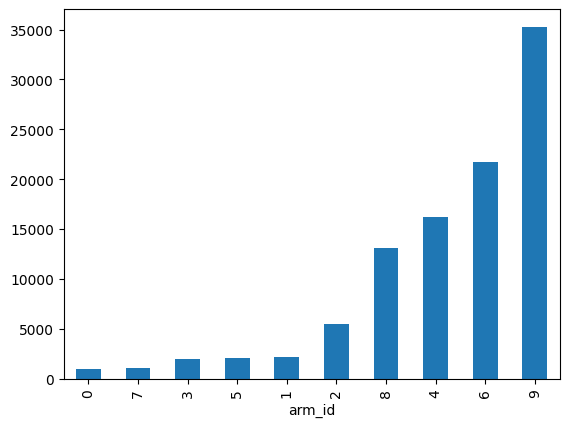

In [7]:
# O anúncio 9 já é o mais visto :)
df_test.groupby("arm_id").client_id.count().sort_values().plot.bar();